In [1]:
!pip install kaggle

!kaggle datasets download -d landlord/handwriting-recognition

!unzip handwriting-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/V

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
train = pd.read_csv('written_name_train_v2.csv')
test = pd.read_csv('written_name_validation_v2.csv')
train_img_dir = 'train_v2/train'
test_img_dir = 'validation_v2/validation'
train.head(6), test.head(6)

(          FILENAME   IDENTITY
 0  TRAIN_00001.jpg  BALTHAZAR
 1  TRAIN_00002.jpg      SIMON
 2  TRAIN_00003.jpg      BENES
 3  TRAIN_00004.jpg    LA LOVE
 4  TRAIN_00005.jpg     DAPHNE
 5  TRAIN_00006.jpg      LUCIE,
               FILENAME    IDENTITY
 0  VALIDATION_0001.jpg       BILEL
 1  VALIDATION_0002.jpg  LAUMIONIER
 2  VALIDATION_0003.jpg         LEA
 3  VALIDATION_0004.jpg   JEAN-ROCH
 4  VALIDATION_0005.jpg        RUPP
 5  VALIDATION_0006.jpg  UNREADABLE)

In [4]:
print("Tain set: ",train['IDENTITY'].shape[0])
print("UNREADABLE in train set : ", train['IDENTITY'].isnull().sum())
print("Test set: ", test['IDENTITY'].shape[0])
print("UNREADABLE in validation set : ", test['IDENTITY'].isnull().sum())


Tain set:  330961
UNREADABLE in train set :  565
Test set:  41370
UNREADABLE in validation set :  78


In [5]:
train = train[train['IDENTITY'] != 'UNREADABLE'] #treure columnes amb imatges que no es pot llegir el contingut
train = train.dropna()
train['IDENTITY'] = train['IDENTITY'].str.upper()
test = test[test['IDENTITY'] != 'UNREADABLE'] #treure columnes amb imatges que no es pot llegir el contingut
test = test.dropna()
train['IDENTITY'] = train['IDENTITY'].str.upper()
print("train:",train.shape[0]," test:",test.shape[0])

train: 330294  test: 41280


In [6]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)
print(len(characters))

30


#### For model to perform better , it must:
* Resize all data to one size (in my case i choose [284,62])
* Convert image from (R,G,B) to binary (1 or 0)

In [7]:
def to_binary(image):
    image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),dsize=(284,62)) #convertir la imatge de BGR a RGB i redimensionarla
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convertir la imatge a escala de grisos
    (thresh, image_binary) = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #aplicar un umbral per separar els pixels de primer pla i de fons de manera òptima
    image_binary = cv2.threshold(image_gray, thresh, 255, cv2.THRESH_BINARY)[1] #aplicar novament un unmbral per asegurar una imatge binaria clara
    image_binary = image_binary / 255 #dividir els valors del pixels entre 255 per obtenir valors de 0 o 1
    return image_binary

## Loading data
* train_data_img   containing all the pictures of train data
* test_data_img   containing all the pictures of test data
* train_data_idt   containing all IDENTITY of train data
* test_data_idt   containing all IDENTITY of test data

In [34]:
train_data_img = [] #emmagatzemar imatges entrenament
train_data_idt = [] #emmagatzemar identitat de les imatges entrenament
#for i in range(test.shape[0]):   #it's take too longe to do all images

for i in range(1000): #iterar els primers 1000 exemples del conjunt d'entrenament
    image_filename = train['FILENAME'].iloc[i] #exreure el nom de l'arxiu de la imatge
    image_path = os.path.join(train_img_dir,image_filename) #concatenar el directori de les imatges d'entrenament amb el nom d'arxiu per obtenir la ruta completa de la imatge
    image = cv2.imread(image_path) #llegir la imatge
    image = to_binary(image) #aplicar funció anterior per convertir la imatge a binari
    train_data_img.append(image) #afegir la imatge binaria a la llista
    train_data_idt.append(train['IDENTITY'].iloc[i]) #afegir la identitat de la imatge

In [35]:
test_data_img = []
test_data_idt = []
#for i in range(test.shape[0]):
for i in range(1000):
    image_filename = test['FILENAME'].iloc[i]
    image_path = os.path.join(test_img_dir,image_filename)
    image = cv2.imread(image_path)
    image = to_binary(image)
    test_data_img.append(image)
    test_data_idt.append(test['IDENTITY'].iloc[i])

BALTHAZAR
(62, 284)


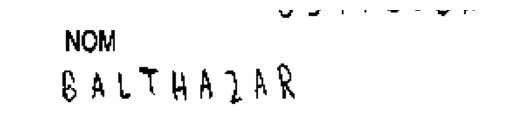

SIMON
(62, 284)


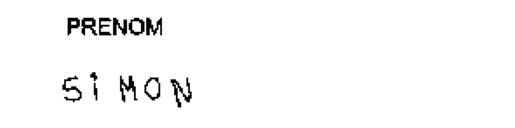

BENES
(62, 284)


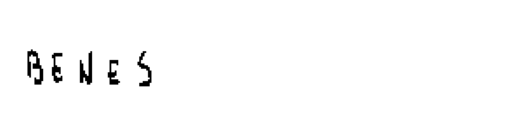

BILEL
(62, 284)


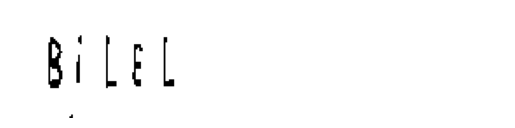

LAUMIONIER
(62, 284)


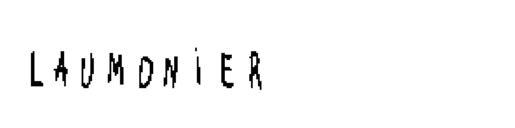

LEA
(62, 284)


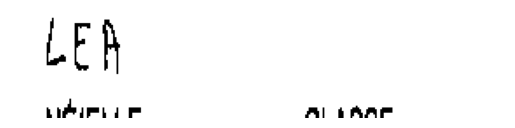

In [10]:
for i in range(3):
    print(train_data_idt[i]) #imprimir una identitat associada a una imatge
    print(train_data_img[i].shape) #imprimir la forma de la imatge
    plt.imshow(train_data_img[i],cmap='gray') #mostrar la imatge en escala de grisos (binari)
    plt.axis('off')
    plt.show()
for i in range(3):
    print(test_data_idt[i])
    print(test_data_img[i].shape)
    plt.imshow(test_data_img[i],cmap='gray')
    plt.axis('off')
    plt.show()

In [31]:
len(train_data_img) , len(test_data_img), len(test_data_idt), len(train_data_idt)

(1000, 1000, 1000, 1000)

In [65]:
LB = LabelBinarizer()
test_Y = LB.fit_transform(test_data_idt)
# Transforma tanto el conjunto de entrenamiento como el de prueba usando el mismo binarizador
train_Y = LB.transform(train_data_idt)
train_X = train_data_img
test_X = test_data_img

train_Y = np.array(train_Y)
test_Y = np.array(test_Y)
train_X = np.array(train_X)
test_X = np.array(test_X)

train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)


In [66]:
print(test_X[5])
train_Y[5]

[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]

 [[0.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[0.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
print(train_X.shape,train_Y.shape)
print(test_X.shape,test_Y.shape)

(1000, 62, 284, 1) (1000, 830)
(1000, 62, 284, 1) (1000, 830)


In [59]:
model = Sequential()

In [60]:
# Capa de entrada ajustada para manejar la nueva dimensión de entrada
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(62, 284,1)))

# Aumentamos la cantidad de filtros en las capas convolucionales para manejar más características
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Podría ser necesario agregar más capas convolucionales dependiendo de la complejidad de los datos
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

# Ajustando la cantidad de neuronas en la capa densa intermedia para manejar más características
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

# La última capa permanece igual, pero asegúrate de que el número de clases sea correcto
model.add(Dense(25, activation='softmax'))

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 284, 32)       320       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 282, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 141, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 139, 128)      73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 69, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 69, 128)      

In [62]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])


In [68]:
history = model.fit(train_X,train_Y, epochs=10, batch_size=32, validation_data = (test_X, test_Y),  verbose=1)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 830) and (None, 25) are incompatible


In [ ]:
plt.hist(history.history['accuracy'], bins=20, edgecolor='black')
plt.title('Training Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()